# Assignment 3: Sequence-to-Sequence Modeling (TA: Kinshuk Vasisht)

In this assignment, you will perform the task of translating Indian Names to Hindi, a sequence-to-sequence modeling task, using character-level conditional language models.

As before, please make a copy of this notebook (locally or on Colab). Ensure you adhere to the guidelines and submission instructions (mentioned below) for attempting and submitting the assignment.

### Guidelines for Attempting the Assignment

1. Write your logic in the cells which have the comment `# ADD YOUR CODE HERE`, between the `# BEGIN CODE` and `# END CODE` comments. These cells are also demarcated by the special start (`## ==== BEGIN EVALUATION PORTION`) and end (`## ==== END EVALUATION PORTION`) comments. Do **NOT** remove any of these comments from the designated cells, otherwise your assigment may not be evaluated correctly.

2. All imports that should be necessary are already provided as part of the notebook. Should you require additional imports, add them in the cells to be graded, but outside the `# BEGIN CODE` and `# END CODE` block. For example, if you need to import a package called `mypackage`, add it as follows in a graded cell:

``` python
## ==== BEGIN EVALUATION PORTION

import mypackage # <===

def function_to_be_implemented(*args, **kwargs):

    ...

    # ADD YOUR CODE HERE
    # BEGIN CODE

    # END CODE

    ...

## ==== END EVALUATION PORTION

```

3. Only write your code in the cells designated for auto-evaluation. If you encounter any errors in the supporting cells during execution, contact the respective TAs.

4. **Important**: Use of AI-assistive technologies such as ChatGPT or GitHub CoPilot is not permitted for this assignment. Ensure that all attempts are solely your own. Not following this rule can incur heavy penalty, including getting NO GRADE for this assignment, which will affect your grade significantly.

### Submission Instructions

1. Ensure your code follows all guidelines mentioned above before submission.

2. Try to avoid any unnecessary print statements across the code. We will evaluate specific output lines which begin with the phrase `EVALUATION`. Ensure you do not modify these print statements howsoever, as they are used for auto-evaluation.

3. When you have completely attempted the assignment, export the current notebook as a `.py` file, with the following name: `SAPName_SRNo_assignment3.py`, where `SAPName` would be your name as per SAP record, and `SRNo` will be the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would use `Twyla_Linda_15329_assignment3.py`.

4. Once you have executed the code, certain additional files will be created. Once you are done executing all associated cells, ensure the folder structure looks as follows:

``` python
└─── SAPName_SRNo
     ├─── SAPName_SRNo_assignment3.py
     ├─── src-tokenizer
     │    └─── tokenizer.pkl
     ├─── tgt-tokenizer
     │    └─── tokenizer.pkl
     ├─── rnn.enc-dec
     │    ├─── model.pt
     │    ├─── loss.json
     │    ├─── outputs.csv
     │    └─── metadata.json
     └─── rnn.enc-dec.attn
          ├─── model.pt
          ├─── loss.json
          ├─── outputs.csv
          └─── metadata.json
```

5. Once you have validated the folder structure as above, add the exported `.py` file to the folder and submit the folder as a ZIP archive.

In the cell below, replace `SAPName` with your name as per SAP record, and `SRNo` with the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would use:

```python
STUDENT_SAP_NAME  = "Twyla Linda"
STUDENT_SR_NUMBER = "15329"
```

In [1]:
STUDENT_SAP_NAME  = "Abhay Patidar"
STUDENT_SR_NUMBER = "22550"

**Important Notes**:

- Some of the tasks in this assignment are compute intensive, and are better performed on an accelerator device (GPU, etc.). Unless you have one locally, prefer using a GPU instance on Colab for execution.
- Due to resource restrictions on Colab, training some models may not finish in time. In such a case, ensure you store checkpoints to a persistent directory so that you may resume training once your resource limits are restored.

## Outline

Through the last assignment, you have seen that neural language models are able to successfully capture patterns across Indian names. In this assignment, you will extend upon that idea to learn conditional language models for the task of transliteration: converting Indian names in the English alphabet to Hindi.

### Marks Distribution

- Tokenization: 20 marks
- Agnostic Task-Specific Training: 5 marks
- Seq-2-Seq via RNN: 40 marks
- Seq-2-Seq via RNN with Attention: 35 marks
- Evaluation
- (**Bonus**) Decoding Strategies: 20 marks

## Setup

The following cells perform the basic setup such as importing the necessary packages.

In [2]:
# Installs packages, if using locally. Feel free to add other missing packages as required.

%pip install tqdm nltk matplotlib numpy pandas

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Built-in imports, no installations required.

import os
import gc
import json
import math
import pickle
import subprocess
import collections
import unicodedata
from queue import PriorityQueue

In [4]:
# 3rd-party package imports, may require installation if not on a platform such as Colab.

import numpy
import torch
import pandas as pd
import tqdm.auto as tqdm

import matplotlib
from matplotlib import pyplot
from nltk.translate import bleu_score
from torch.utils.data import TensorDataset, DataLoader

In [5]:
# Please do not change anything in the following cell

# Find and load fonts that can display Hindi characters, for Matplotlib
result = subprocess.run([ 'fc-list', ':lang=hi', 'family' ], capture_output=True)
found_hindi_fonts = result.stdout.decode('utf-8').strip().split('\n')

matplotlib.rcParams['font.sans-serif'] = [
    'Source Han Sans TW', 'sans-serif', 'Arial Unicode MS',
    *found_hindi_fonts
]

In [6]:
# Please do not change anything in the following cell

DIRECTORY_NAME = f"{STUDENT_SAP_NAME.replace(' ', '_')}_{STUDENT_SR_NUMBER}"

os.makedirs(DIRECTORY_NAME, exist_ok=True)

In [7]:
def sync_vram():
    """ Synchronizes the VRAM across the GPUs, reclaiming unused memory. """
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

## Data Preparation

We'll load the data for the task, which comprises of a parallel corpus of Indian Names and their Hindi equivalents.

In [8]:
# Make sure your code is not dependent on any of the file names as below.

# Download the training and validation datasets
# !wget -O data.train.csv "https://docs.google.com/spreadsheets/d/1JpK9nOuZ2ctMrjNL-C0ghUQ4TesTrMER1-dTD_torAA/gviz/tq?tqx=out:csv&sheet=data.train.csv"
# !wget -O data.valid.csv "https://docs.google.com/spreadsheets/d/1cKC0WpWpIQJkaqnFb7Ou7d0syFDsj6eEW7bM7GH3u2k/gviz/tq?tqx=out:csv&sheet=data.valid.csv"

In [9]:
# Please do not change anything in the following cell

def read_dataframe(ds_type):
    """ Loads a dataframe based on the given partition type.

    Args:
        ds_type (str): Dataset type: train (train) or validation (valid)

    Returns:
        pd.DataFrame: Pandas Dataframe for the specified partition.
    """

    df = pd.read_csv(f"data.{ds_type}.csv", header=0)
    df = df[~df.isna()]
    df['Name'] = df['Name'].astype(str)
    df['Translation'] = df['Translation'].astype(str)
    return df

# Load the training and validation datasets
train_data      = read_dataframe("train")
validation_data = read_dataframe("valid")

print(f"Length of training data: {len(train_data)}\nLength of validation data: {len(validation_data)}")

Length of training data: 4484
Length of validation data: 400


Here are some examples from the training dataset. Note that the dataset may be noisy so some examples may not be perfect:

In [10]:
train_data.sample(n=5)

,Name,Translation
3691,sharda,शारदा
2353,nadir,नादिर
1849,kumud,कुमुद
378,asmita,आस्मिता
2382,najda,नाजदा


## Tokenization

Now with the data, you must first prepare a tokenization strategy for feeding name pairs as a sequence to different models. For English this could be as simple as using individual characters as tokens, but Hindi has accents (मात्राएँ), a larger set of vowels (स्वर), consonants (व्यंजन), and additional composition rules (half-letters, etc.), so such a simple strategy may not be effective.

In NLP literature, multiple strategies exist for automatically learning a suitable sub-word tokenization strategy from the given data. Such tokenizers exist in two types:
- Given a set of initial tokens, learn suitable combinations which are added as new tokens until a certain vocabulary size is reached. Examples of these include [BPE Tokenization](https://arxiv.org/abs/1508.07909) and [WordPiece Tokenization, introduced by the BERT paper](https://arxiv.org/abs/1810.04805).
- Given a large set of initial tokens, learn suitable rules to reduce the size of the vocabulary to a desired size. An example of this includes [SentencePiece Tokenization](https://arxiv.org/abs/1808.06226).

Given empirical results, these are popular strategies to learn tokenization automatically from given data.

In this section, you will implement a tokenizer for the given data. There could be multiple strategies to implement tokenizers:
- You can have a tokenizer that operates jointly over both languages or have separate tokenizers for English and Hindi.
- Your tokenizer can learn the tokenization from data (using any one of the techniques mentioned above) or can use a fixed set of rules for decomposition.

Implement the logic for any tokenizer of your choice in the class `Tokenizer` below. Make sure to adhere to the rules and constraints in the docstrings.

The tokenizer will learn a mapping of tokens to ids and vice versa and use these to map strings. This mapping can be built based on merge rules (BPE, WordPiece, etc.) or hand-crafted rules, in the `Tokenizer.train()` function. Additionally the tokenizer will also handle preprocessing and postprocessing of strings during the encoding phase (string to tokens).

In [11]:
## ==== BEGIN EVALUATION PORTION

class Tokenizer:
    """ Represents the tokenizer for text data.
        Provides methods to encode and decode strings (as instance or as a batch). """

    def __init__(self):
        """ Initializes a new tokenizer.

            Any variables required in intermediate operations are declared here.
            You will also need to define things like special tokens and other things here.

            All variables declared in this function will be serialized
                and deserialized when loading and saving the Tokenizer.
            """

        # BEGIN CODE : tokenizer.init

        # ADD YOUR CODE HERE
        self.vocab = None
        self.temp_vocab = {}
        self.PAD_TOKEN = '[PAD]'
        self.START_TOKEN = '[SOS]'
        self.END_TOKEN = '[EOS]'
        self.UNK_TOKEN = '<UNK>'
        self.special_token_count = 4
        # END CODE

    @classmethod
    def load(cls, path):
        """ Loads a pre-trained tokenizer from the given directory.
           This directory will have a tokenizer.pkl file that contains all the tokenizer variables.

        Args:
            path (str): Path to load the tokenizer from.
        """
        tokenizer_file = os.path.join(path, "tokenizer.pkl")

        if not os.path.exists(path) or not os.path.exists(os.path.join(path, "tokenizer.pkl")):
            raise ValueError(cls.load.__name__ + ": No tokenizer found at the specified directory")

        with open(tokenizer_file, "rb") as ifile:
            return pickle.load(ifile)

    def save(self, path):
        """ Saves a trained tokenizer to a given directory, inside a tokenizer.pkl file.

        Args:
            path (str): Directory to save the tokenizer in.
        """

        os.makedirs(path, exist_ok=True)
        with open(os.path.join(path, "tokenizer.pkl"), 'wb') as ofile:
            pickle.dump(self, ofile)

    def train(self, data, vocab_size):
        """ Trains a tokenizer to learn meaningful representations from input data.
            In the end, learns a vocabulary of a fixed size over the given data.
            Special tokens, if any, must not be counted towards this vocabulary.

        Args:
            data (list[str]): List of input strings from a text corpus.
            vocab_size (int): Final desired size of the vocab to be learnt.
        """

        # BEGIN CODE : tokenizer.train

        # ADD YOUR CODE HERE
        def get_frequencies(vocab):
            pairs = collections.defaultdict(int)
            for word, freq in vocab.items():
                tokens = word.split()
                for i in range(len(tokens) - 1):
                    pairs[tokens[i], tokens[i + 1]] += freq
            return pairs

        def merge_vocab(pair, vocab):
            new_vocab = {}
            bigram = ' '.join(pair)
            for word in vocab:
                w_out = word.replace(bigram, ''.join(pair))
                new_vocab[w_out] = vocab[word]
            return new_vocab
        
        def create_vocab(data):
            vocab = collections.defaultdict(int)
            for word in data:
                word = ' '.join(word)
                vocab[word] += 1
            return vocab
        
        def getSingleTokens(data):
            for word in data:
                for char in word:
                    self.temp_vocab[char] = 1

        getSingleTokens(data)
        # print(len(self.temp_vocab))
        data = create_vocab(data)
        pairs = get_frequencies(data)

        while(len(self.temp_vocab) < (vocab_size-4) and len(pairs) > 1):
            pairs = get_frequencies(data)
            best_pair = max(pairs, key=pairs.get)
            self.temp_vocab[best_pair[0]] = 1
            if len(self.temp_vocab) < (vocab_size-4):
                self.temp_vocab[best_pair[1]] = 1
            if len(self.temp_vocab) < (vocab_size-4):
                self.temp_vocab[''.join(best_pair)] = 1
            data = merge_vocab(best_pair, data)
        # END CODE


    def pad(self, tokens, length):
        """ Pads a tokenized string to a specified length, for batch processing.

        Args:
            tokens (list[int]): Encoded token string to be padded.
            length (int): Length of tokens to pad to.

        Returns:
            list[int]: Token string padded to desired length.
        """

        # BEGIN CODE : tokenizer.pad

        # ADD YOUR CODE HERE
        if self.vocab is None:
            self.get_vocabulary()
        if(len(tokens) < length):
            return tokens + [self.vocab[self.PAD_TOKEN]]*(length-len(tokens))
        else:
            return tokens
        # END CODE

    def unpad(self, tokens):
        """ Removes padding from a token string.

        Args:
            tokens (list[int]): Encoded token string with padding.

        Returns:
            list[int]: Token string with padding removed.
        """

        # BEGIN CODE : tokenizer.unpad

        # ADD YOUR CODE HERE
        if self.vocab is None:
            self.get_vocabulary()
        while(len(tokens) > 0 and tokens[-1] == self.vocab[self.PAD_TOKEN]):
            tokens = tokens[:-1]
        return tokens
        # END CODE

    def get_special_tokens(self):
        """ Returns the associated special tokens.

            Returns:
                dict[str, int]: Mapping describing the special tokens, if any.
                    This is a mapping between a string segment (token) and its associated id (token_id).
        """

        # BEGIN CODE : tokenizer.get_special_tokens

        # ADD YOUR CODE HERE
        return {
            self.START_TOKEN : 0,
            self.END_TOKEN : 1,
            self.PAD_TOKEN : 2,
            self.UNK_TOKEN : 3
        }
        # END CODE

    def get_vocabulary(self):
        """ Returns the learnt vocabulary post the training process.

            Returns:
                dict[str, int]: Mapping describing the vocabulary and special tokens, if any.
                    This is a mapping between a string segment (token) and its associated id (token_id).
        """

        # BEGIN CODE : tokenizer.get_vocabulary

        # ADD YOUR CODE HERE
        self.vocab = self.get_special_tokens()
        index = len(self.vocab)
        for token in self.temp_vocab.keys():
            if token not in self.vocab.keys():
                self.vocab[token] = index
                index += 1
        return self.vocab
        # END CODE

    def encode(self, string, add_start=True, add_end=True):
        """ Encodes a string into a list of tokens.

        Args:
            string (str): Input string to be tokenized.
            add_start (bool): If true, adds the start of sequence token.
            add_end (bool): If true, adds the end of sequence token.
        Returns:
            list[int]: List of tokens (unpadded).
        """

        # BEGIN CODE : tokenizer.encode

        # ADD YOUR CODE HERE
        if self.vocab is None:
            self.get_vocabulary()
        encoded_list = []
        if(add_start):
            encoded_list.append(self.vocab[self.START_TOKEN])
        start = 0
        end = len(string)
        while(start < end):
            if(string[start:end] in self.vocab.keys()):
                encoded_list.append(self.vocab[string[start:end]])
                start = end
                end = len(string)
            elif(start+1<end):
                end -= 1
            else:
                encoded_list.append(self.vocab[self.UNK_TOKEN])
                start += 1
                end = len(string)
        if(add_end):
            encoded_list.append(self.vocab[self.END_TOKEN])    
        return encoded_list
        # END CODE

    def decode(self, tokens, strip_special=True):
        """ Decodes a string from a list of tokens.
            Undoes the tokenization, returning back the input string.

        Args:
            tokens (list[int]): List of encoded tokens to be decoded. No padding is assumed.
            strip_special (bool): Whether to remove special tokens or not.

        Returns:
            str: Decoded string.
        """

        # BEGIN CODE : tokenizer.decode
        # ADD YOUR CODE HERE

        if self.vocab is None:
            self.get_vocabulary()

        if(strip_special and len(tokens) > 0 and tokens[0] == self.vocab[self.START_TOKEN]):
            tokens = tokens[1:]
        if(strip_special and len(tokens) > 0 and tokens[-1] == self.vocab[self.END_TOKEN]):
            tokens = tokens[:-1]
        str = ""
        get_key_by_value = lambda d, val: next((key for key, value in d.items() if value == val), None)
        if(strip_special and len(tokens) > 0 and tokens[0] == self.vocab[self.START_TOKEN]):
            tokens = tokens[1:]
        if(strip_special and len(tokens) > 0 and tokens[-1] == self.vocab[self.END_TOKEN]):
            tokens = tokens[:-1]
        for token in tokens:
            char = get_key_by_value(self.vocab, token)
            if char is not None:
                str +=  char
        return str
        # END CODE


    def batch_encode(self, batch, padding=None, add_start=True, add_end=True):
        """Encodes multiple strings in a batch to list of tokens padded to a given size.

        Args:
            batch (list[str]): List of strings to be tokenized.
            padding (int, optional): Optional, desired tokenized length. Outputs will be padded to fit this length.
            add_start (bool): If true, adds the start of sequence token.
            add_end (bool): If true, adds the end of sequence token.

        Returns:
            list[list[int]]: List of tokenized outputs, padded to the same length.
        """

        batch_output = [ self.encode(string, add_start, add_end) for string in batch ]
        if padding:
            for i, tokens in enumerate(batch_output):
                if len(tokens) < padding:
                    batch_output[i] = self.pad(tokens, padding)
        return batch_output

    def batch_decode(self, batch, strip_special=True):
        """ Decodes a batch of encoded tokens to normal strings.

        Args:
            batch (list[list[int]]): List of encoded token strings, optionally padded.
            strip_special (bool): Whether to remove special tokens or not.

        Returns:
            list[str]: Decoded strings after padding is removed.
        """
        return [ self.decode(self.unpad(tokens), strip_special=strip_special) for tokens in batch ]

## ==== END EVALUATION PORTION

Now with the tokenizer class, initialize and train the tokenizers for processing the parallel corpus:

In [12]:
## ==== BEGIN EVALUATION PORTION

# BEGIN CODE : tokenizer.create

# Initialize the tokenizers as per the desired strategy.
# ADD YOUR CODE HERE
# initial_hi_vocab = [chr(i) for i in range(0x0900, 0x097F)]
# initial_en_vocab = [chr(i) for i in range(97, 123)]
# print(initial_hi_vocab)
# src_tokenizer = Tokenizer()
# tgt_tokenizer = Tokenizer()
with open("Abhay_Patidar_22550/src_tokenizer/tokenizer.pkl", "rb") as f:
    src_tokenizer = pickle.load(f)
with open("Abhay_Patidar_22550/tgt_tokenizer/tokenizer.pkl", "rb") as f:
    tgt_tokenizer = pickle.load(f)
# END CODE

## ==== END EVALUATION PORTION

In [13]:
## ==== BEGIN EVALUATION PORTION

# Edit the hyperparameters below as desired.
SRC_VOCAB_SIZE = 75
TGT_VOCAB_SIZE = 100

# BEGIN CODE : tokenizer.training

# Train your tokenizer(s)
# ADD YOUR CODE HERE
# src_tokenizer.train(list(train_data["Name"]), SRC_VOCAB_SIZE)
# tgt_tokenizer.train(list(train_data["Translation"]), TGT_VOCAB_SIZE)
# END CODE

## ==== END EVALUATION PORTION

In [14]:
# Please do not change anything in the following cell

# Save the trained tokenizers
src_tokenizer.save(os.path.join(DIRECTORY_NAME, "src_tokenizer"))
tgt_tokenizer.save(os.path.join(DIRECTORY_NAME, "tgt_tokenizer"))

In [15]:
# Please do not change anything in the following cell

def render_glyph(token):
    """ Renders a token, handling invalid bytes in a safe, error-proof manner. """

    token = token.decode('utf-8', errors='replace') if isinstance(token, bytes) else token
    return "".join([ c if unicodedata.category(c)[0] != "C" else f"\\u{ord(c):04x}" for c in token ])

def inverse_vocabulary(tokenizer):
    """ Generates an inverse vocabulary with rendered tokens.

    Args:
        tokenizer (Tokenizer): Tokenizer whose vocabulary must be used.
    """

    return { id: render_glyph(token) for token, id in tokenizer.get_vocabulary().items() }

def apply_inverse_vocab(tokens, inv_vocab):
    """ Decodes using the given inverse vocabulary.

    Args:
        tokens (list[int]): Tokens to process.
        inv_vocab (dict[int, str]): Inverse vocabulary for mapping ids to tokens.

    Returns:
        list[str]: Mapped token glyphs.
    """

    return [ inv_vocab[id] for id in tokens ]

We visualize a few outputs of the learnt tokenizers to assess their working:

In [16]:
# Please do not change anything in the following cell

src_id_to_token = inverse_vocabulary(src_tokenizer)

for example in train_data['Name'].sample(n=5, random_state=20240227):
    print("Name           :", example)
    tokens = src_tokenizer.encode(example)
    print("Tokens         :", tokens)
    print("Tokens (glyphs):", apply_inverse_vocab(tokens, src_id_to_token))
    print("Decoded        :", src_tokenizer.decode(tokens), end='\n\n')

Name           : prya
Tokens         : [0, 25, 11, 48, 1]
Tokens (glyphs): ['[SOS]', 'p', 'r', 'ya', '[EOS]']
Decoded        : prya

Name           : jamal
Tokens         : [0, 50, 46, 12, 1]
Tokens (glyphs): ['[SOS]', 'ja', 'ma', 'l', '[EOS]']
Decoded        : jamal

Name           : jag
Tokens         : [0, 50, 17, 1]
Tokens (glyphs): ['[SOS]', 'ja', 'g', '[EOS]']
Decoded        : jag

Name           : sampat
Tokens         : [0, 43, 21, 74, 16, 1]
Tokens (glyphs): ['[SOS]', 'sa', 'm', 'pa', 't', '[EOS]']
Decoded        : sampat

Name           : amar
Tokens         : [0, 41, 37, 1]
Tokens (glyphs): ['[SOS]', 'am', 'ar', '[EOS]']
Decoded        : amar



In [17]:
# Please do not change anything in the following cell

tgt_id_to_token = inverse_vocabulary(tgt_tokenizer)

for example in train_data['Translation'].sample(n=5, random_state=20240227):
    print("Name           :", example)
    tokens = tgt_tokenizer.encode(example)
    print("Tokens         :", tokens)
    print("Tokens (glyphs):", apply_inverse_vocab(tokens, tgt_id_to_token))
    print("Decoded        :", tgt_tokenizer.decode(tokens), end='\n\n')

Name           : प्र्या
Tokens         : [0, 83, 15, 69, 1]
Tokens (glyphs): ['[SOS]', 'प्र', '्', 'या', '[EOS]']
Decoded        : प्र्या

Name           : जमाल
Tokens         : [0, 24, 67, 14, 1]
Tokens (glyphs): ['[SOS]', 'ज', 'मा', 'ल', '[EOS]']
Decoded        : जमाल

Name           : जग
Tokens         : [0, 24, 22, 1]
Tokens (glyphs): ['[SOS]', 'ज', 'ग', '[EOS]']
Decoded        : जग

Name           : सम्पत्ति
Tokens         : [0, 31, 28, 15, 42, 21, 15, 89, 1]
Tokens (glyphs): ['[SOS]', 'स', 'म', '्', 'प', 'त', '्', 'ति', '[EOS]']
Decoded        : सम्पत्ति

Name           : अमर
Tokens         : [0, 35, 28, 13, 1]
Tokens (glyphs): ['[SOS]', 'अ', 'म', 'र', '[EOS]']
Decoded        : अमर



In [18]:
# Please do not change anything in the following cell

# Run some tests to ensure your tokenizer implementation works as intended.

instances = train_data['Translation'].sample(n=5, random_state=20240227).tolist()

try:
    max_length = max(map(
        lambda x: len(tgt_tokenizer.encode(x, add_start=False, add_end=False)),
        instances
    ))

    # Batch encode all instances with 'max' padding':
    tokenized_instances = tgt_tokenizer.batch_encode(
        instances, padding=max_length, add_start=False, add_end=False
    )

    # Check if length of encoded strings is consistent with the expected length.
    assert all(len(tok_str) == max_length for tok_str in tokenized_instances)

except AssertionError:
    print((
        "[!] Your tokenizer does not encode strings correctly, "
        "ensure you have implemented padding appropriately!"
    ))

try:
    max_length = max(map(
        lambda x: len(tgt_tokenizer.encode(x, add_start=True, add_end=True)),
        instances
    ))

    # Batch encode all instances with 'max' padding':
    tokenized_instances = tgt_tokenizer.batch_encode(
        instances, padding=max_length, add_start=True, add_end=True
    )

    # Check if length of encoded strings is consistent with the expected length.
    assert all(len(tok_str) == max_length for tok_str in tokenized_instances)

    # # Check if all strings start with the correct 'start' tokens.
    assert all(tok_str[0] == tokenized_instances[0][0] for tok_str in tokenized_instances)

    # # Check if all strings end with the correct 'end' tokens.
    end_i = [ i for i, seq in enumerate(tokenized_instances) if len(tgt_tokenizer.unpad(seq)) == max_length ]
    pad_i = [ i for i, seq in enumerate(tokenized_instances) if len(tgt_tokenizer.unpad(seq)) <  max_length ]

    assert all(
        tokenized_instances[i][-1] == tokenized_instances[end_i[0]][-1]
        for i in end_i
    )
    assert all(
        tokenized_instances[i][-1] == tokenized_instances[pad_i[0]][-1]
        for i in pad_i
    )
    pad_lengths = [ tokenized_instances[i].index(tokenized_instances[end_i[0]][-1]) for i in pad_i ]
    assert all(
        all(tok == tokenized_instances[pad_i[0]][-1] for tok in tokenized_instances[i][plen+1:])
        for i, plen in zip(pad_i, pad_lengths)
    )

except AssertionError:
    print((
        "[!] Your tokenizer does not encode strings correctly, "
        "ensure you have used start and end tokens appropriately!"
    ))

We now abstract away the tokenizer into a pytorch compatible TokenizedDataset that will handle the tokenization internally:

In [19]:
# Please do not change anything in the following cell

class TokenizerDataset(TensorDataset):
    """ Abstraction of the tokenizer functions as a pytorch dataset. """

    def __init__(self, data, src_tokenizer, tgt_tokenizer, src_padding=None, tgt_padding=None):
        """ Initializes the dataset.

        Args:
            data: DataFrame of input and output strings.
            src_tokenizer (Tokenizer): Tokenizer for the source language.
            tgt_tokenizer (Tokenizer): Tokenizer for the target language.
            src_padding (int, optional): Padding length for the source text. Defaults to None.
            tgt_padding (int, optional): Padding length for the target text. Defaults to None.
        """

        self.data = data
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.src_padding = src_padding
        self.tgt_padding = tgt_padding

    def collate(self, batch):
        """ Collates data instances into a batch of tokenized tensors.

        Args:
            batch (list[tuple]): List of x, y pairs.

        Returns:
            tuple[torch.Tensor|PackedSequence, torch.Tensor|PackedSequence]: pair of tokenized tensors.
        """

        x_batch = [ data[0] for data in batch ]
        y_batch = [ data[1] for data in batch ]

        x_batch = self.src_tokenizer.batch_encode(x_batch, self.src_padding)
        y_batch = self.tgt_tokenizer.batch_encode(y_batch, self.tgt_padding)

        if self.src_padding is None:
            x_batch = torch.nn.utils.rnn.pack_sequence([ torch.tensor(tokens) for tokens in x_batch ], False)
        else:
            x_batch = torch.tensor(x_batch)

        if self.tgt_padding is None:
            y_batch = torch.nn.utils.rnn.pack_sequence([ torch.tensor(tokens) for tokens in y_batch ], False)
        else:
            y_batch = torch.tensor(y_batch)

        return x_batch, y_batch

    def __getitem__(self, index):
        """ Returns the nth instance from the dataset.

        Args:
            index (int): Index of the instance to retrieve.

        Returns:
            tuple[str, str]: Untokenized instance pair.
        """

        return (
            self.data['Name'][index],
            self.data['Translation'][index]
        )

    def __len__(self):
        """ Returns the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.data)

## Model-Agnostic Training

Next, you'll implement a Trainer to train different models, since the data and tokenizer remains the same for all models.

This trainer will receive the model, a loss function, an optimizer, a training and (optionally) a validation dataset and use these to train (and validate) the model.

The trainer will also take care of handling checkpoints for training, which can be used to resume training across sessions.

Derived classes can also be defined to handle different architectures, as to be done in the model-specific classes below.

In [20]:
## ==== BEGIN EVALUATION PORTION

class Trainer:
    """ Performs model training in a model-agnostic manner.
        Requires specifying the model instance, the loss criterion to optimize,
          the optimizer to use and the directory to save data to.
    """

    def __init__(self, directory, model, criterion, optimizer):
        """ Initializes the trainer.

        Args:
            directory (str): Directory to save checkpoints and the model data in.
            model (torch.nn.Module): Torch model (must inherit `torch.nn.Module`) to train.
            criterion (torch.nn.Function): Loss criterion, i.e., the loss function to optimize for training.
            optimizer (torch.optim.Optimizer): Optimizer to use for training.
        """

        self.model            = model
        self.optimizer        = optimizer
        self.criterion        = criterion
        self.directory        = directory
        self.last_checkpoint  = 0
        self.loss_history     = { 'train': [], 'valid': [] }

        os.makedirs(self.directory, exist_ok=True)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    @staticmethod
    def make_dataloader(dataset, shuffle_data=True, batch_size=8, collate_fn=None):
        """ Create a dataloader for a torch Dataset.

        Args:
            dataset (torch.utils.data.Dataset): Dataset to process.
            shuffle_data (bool, optional): If true, shuffles the data. Defaults to True.
            batch_size (int, optional): Number of items per batch. Defaults to 8.
            collate_fn (function, optional): Function to use for collating instances to a batch.

        Returns:
            torch.utils.data.DataLoader: Dataloader over the given data, post processing.
        """

        # BEGIN CODE : trainer.make_dataloader

        # ADD YOUR CODE HERE
        
        dataloader = DataLoader(
            dataset, 
            batch_size = batch_size,
            shuffle = shuffle_data,
            collate_fn = collate_fn
        )
        
        return dataloader
        # END CODE

    def train_step(self, x_batch, y_batch):
        """ Performs a step of training, on the training batch.

        Args:
            x_batch (torch.Tensor): Input batch.
            y_batch (torch.Tensor): Output batch.

        Returns:
            float: Training loss with the current model, on this batch.
        """

        # BEGIN CODE : trainer.train_step

        # ADD YOUR CODE HERE
        self.model.train()
        self.optimizer.zero_grad()
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)
        output = self.model(x_batch)
        loss = self.criterion(output, y_batch)
        loss.backward()
        self.optimizer.step()
        # self.loss_history["train"].append(loss.item())
        return loss.item()
        # END CODE

    def eval_step(self, validation_dataloader):
        """ Perfoms an evaluation step, on the validation dataloader.

        Args:
            validation_dataloader (torch.utils.data.DataLoader): Dataloader for the validation dataset.

        Returns:
            float: Validation loss with the current model checkpoint.
        """

        # BEGIN CODE : trainer.eval_step

        # ADD YOUR CODE HERE
        self.model.eval()
        loss_sum = 0
        with torch.no_grad():
            for batch_data in validation_dataloader:
                x_batch = batch_data[0]
                y_batch = batch_data[1]
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                output = self.model(x_batch)
                loss = self.criterion(output, y_batch)
                loss_sum += loss.item()
            return loss_sum/len(validation_dataloader)
        # END CODE

    def train(self, train_dataset, validation_dataset=None,
              num_epochs=10, batch_size=8, shuffle=True,
              save_steps=100, eval_steps=100, collate_fn=None):
        """ Handles the training loop for the model.

        Args:
            train_dataset (torch.utils.data.Dataset): Dataset to train on.
            validation_dataset (torch.utils.data.Dataset, optional): Data to validate on. Defaults to None.
            num_epochs (int, optional): Number of epochs to train for. Defaults to 10.
            batch_size (int, optional): Number of items to process per batch. Defaults to 8.
            shuffle (bool, optional): Whether to shuffle the data or not. Defaults to True.
            save_steps (int, optional): Number of steps post which a checkpoint should be saved. Defaults to 100.
            eval_steps (int, optional): Number of steps post which the model should be evaluated. Defaults to 100.
            collate_fn (function, optional): Function to use for collating instances to a batch.
        """

        current_checkpoint = 0
        self.model.to(self.device)
        self.model.train()

        with tqdm.tqdm(total = math.ceil(len(train_dataset) / batch_size) * num_epochs) as pbar:
            for epoch in range(num_epochs):
                train_dataloader      = self.make_dataloader(train_dataset, shuffle, batch_size, collate_fn)
                if validation_dataset is not None:
                    validation_dataloader = self.make_dataloader(validation_dataset, shuffle, batch_size, collate_fn)
                
                for batch, (x_batch, y_batch) in enumerate(train_dataloader):
                    pbar.set_description(f"Epoch {epoch+1} / {num_epochs}")

                    # If we are resuming training, skip this iteration
                    if current_checkpoint < self.last_checkpoint:
                        current_checkpoint += 1
                        pbar.update()
                        continue

                    # Do a step of training
                    loss = self.train_step(x_batch, y_batch)
                    self.loss_history['train'].append(loss)
                    pbar.set_postfix({ 'batch': batch+1, 'loss': loss })

                    current_checkpoint += 1
                    pbar.update()

                    # Evaluate after every eval_steps
                    if (current_checkpoint) % eval_steps == 0:
                        if validation_dataset is not None:
                            val_loss = self.eval_step(validation_dataloader)
                            self.loss_history['valid'].append(val_loss)
                        else:
                            val_loss = None

                        print('[>]', f"epoch #{epoch+1:{len(str(num_epochs))}},",
                              f"batch #{batch+1:{len(str(len(train_dataloader)))}}:",
                              "loss:", f"{loss:.8f}", '|', "val_loss:", f"{val_loss:.8f}")

                    # Save after every save_steps
                    if (current_checkpoint) % save_steps == 0:
                        self.save(current_checkpoint, { 'loss': loss, 'checkpoint': current_checkpoint })

                    # free unused resources
                    sync_vram()

            self.save(current_checkpoint)

    def resume(self):
        """ Resumes training session from the most recent checkpoint. """

        if checkpoints := os.listdir(self.directory):
            self.last_checkpoint = max(map(lambda x: int(x[11:]), filter(lambda x: 'checkpoint-' in x, checkpoints)))
            checkpoint_dir = os.path.join(self.directory, f"checkpoint-{self.last_checkpoint}")
            self.model.load_state_dict(torch.load(
                os.path.join(checkpoint_dir, "model.pt"),
                map_location=self.device
            ))
            self.model.to(self.device)
            self.optimizer.load_state_dict(torch.load(
                os.path.join(checkpoint_dir, "optimizer.pt"),
                map_location=self.device
            ))
            with open(os.path.join(checkpoint_dir, "loss.json"), 'r', encoding='utf-8') as ifile:
                self.loss_history = json.load(ifile)

    def save(self, checkpoint=None, metadata=None):
        """ Saves an associated model or a training checkpoint.

            If a checkpoint is specified, saves a checkpoint specific directory with optimizer data
                so that training can be resumed post that checkpoint.

        Args:
            checkpoint (int, optional): Checkpoint index. Defaults to None.
            metadata (dict[str, any], optional): Additional metadata to save alongside a checkpoint. Defaults to None.
        """

        if checkpoint is not None:
            checkpoint_dir = os.path.join(self.directory, f"checkpoint-{checkpoint}")
            os.makedirs(checkpoint_dir, exist_ok=True)
            torch.save(self.model.state_dict(), os.path.join(checkpoint_dir, "model.pt"))
            torch.save(self.optimizer.state_dict(), os.path.join(checkpoint_dir, "optimizer.pt"))
            with open(os.path.join(checkpoint_dir, "loss.json"), "w+", encoding='utf-8') as ofile:
                json.dump(self.loss_history, ofile, ensure_ascii=False, indent=2)
            if metadata:
                with open(os.path.join(checkpoint_dir, "metadata.json"), "w+", encoding='utf-8') as ofile:
                    json.dump(metadata, ofile, ensure_ascii=False, indent=2)
        else:
            torch.save(self.model, os.path.join(self.directory, "model.pt"))
            with open(os.path.join(self.directory, "loss.json"), "w+", encoding='utf-8') as ofile:
                json.dump(self.loss_history, ofile, ensure_ascii=False, indent=2)
            if metadata:
                with open(os.path.join(self.directory, "metadata.json"), "w+", encoding='utf-8') as ofile:
                    json.dump(metadata, ofile, ensure_ascii=False, indent=2)

## ==== END EVALUATION PORTION



```
# This is formatted as code
```

To test that the trainer works, try training a simple MLP network:

In [21]:
# X_train = torch.rand((500, 2))                      # (N x 2)
# X_dev   = torch.rand((20 , 2))                      # (N x 2)

# Y_train = (X_train[:, 0] - X_train[:, 1])[:, None]  # (N x 1)
# Y_dev   = (X_dev  [:, 0] - X_dev  [:, 1])[:, None]  # (N x 1)

# dummy_train_dataset = TensorDataset(X_train, Y_train)
# dummy_val_dataset   = TensorDataset(X_dev  , Y_dev  )

In [22]:
# model = torch.nn.Sequential(
#     torch.nn.Linear(2, 4),
#     torch.nn.ReLU(),
#     torch.nn.Linear(4, 1)
# )

# loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer = Trainer("mlp", model, loss_fn, optimizer)
# trainer.train(dummy_train_dataset, dummy_val_dataset, batch_size=10, save_steps=300)

## Seq-2-Seq Modeling with RNNs

In this section, you will implement an encoder-decoder network using RNNs, to learn a conditional language model for the task of translating the names to Hindi.

You can use any type of RNN for this purpose: `RNN`, `GRU`, `LSTM`, etc. Consult the pytorch documentation for additional information.

Additional tips for training:
- Use regularization: Dropout, etc.
- Use a suitable optimizer, such as Adam.
- Format data accordingly before passing it to the trainer, using the helper functions.
- Do you need to pad sequences when processing inputs as a batch?

In [23]:
## ==== BEGIN EVALUATION PORTION

class RNNEncoderDecoderLM(torch.nn.Module):
    """ Implements an Encoder-Decoder network, using RNN units. """

    # Feel free to add additional parameters to __init__
    def __init__(self, src_vocab_size, tgt_vocab_size, embd_dims, hidden_size, num_layers=1, dropout=0.1):
        """ Initializes the encoder-decoder network, implemented via RNNs.

        Args:
            src_vocab_size (int): Source vocabulary size.
            tgt_vocab_size (int): Target vocabulary size.
            embd_dims (int): Embedding dimensions.
            hidden_size (int): Size/Dimensions for the hidden states.
        """

        super(RNNEncoderDecoderLM, self).__init__()

        # Dummy parameter to track the model device. Do not modify.
        self._dummy_param = torch.nn.Parameter(torch.Tensor(0), requires_grad=False)

        # BEGIN CODE : enc-dec-rnn.init

        # ADD YOUR CODE HERE
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.embd_dims = embd_dims
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.embed_layer_encoder = torch.nn.Embedding(src_vocab_size, embd_dims)
        self.lstm_encoder = torch.nn.GRU(embd_dims, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.embed_layer_decoder = torch.nn.Embedding(tgt_vocab_size, embd_dims)
        self.lstm_decoder = torch.nn.GRU(embd_dims, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # self.transform_layer = torch.nn.Linear(hidden_size, embd_dims)
        self.output_layer = torch.nn.Linear(hidden_size, tgt_vocab_size)
        # END CODE

    @property
    def device(self):
        """ Returns the device the model parameters are on. """
        return self._dummy_param.device

    def forward(self, inputs, decoder_inputs, decoder_hidden_state=None):
        """ Performs a forward pass over the encoder-decoder network.

            Accepts inputs for the encoder, inputs for the decoder, and hidden state for
                the decoder to continue generation after the given input.

        Args:
            inputs (torch.Tensor): tensor of shape [batch_size?, max_seq_length]
            decoder_inputs (torch.Tensor): tensor of shape [batch_size?, 1]
            decoder_hidden_state (any): tensor to represent decoder hidden state from time step T-1.

        Returns:
            tuple[torch.Tensor, any]: output from the decoder, and associated hidden state for the next step.
            Decoder outputs should be log probabilities over the target vocabulary.
        """

        # BEGIN CODE : enc-dec-rnn.forward

        # ADD YOUR CODE HERE
        if decoder_hidden_state is None:
            output = self.embed_layer_encoder(inputs)
            output, hidden_state = self.lstm_encoder(output)
            decoder_inputs = self.embed_layer_decoder(decoder_inputs)
            output, hidden_state = self.lstm_decoder(decoder_inputs, hidden_state)
        else:
            decoder_inputs = self.embed_layer_decoder(decoder_inputs)
            output, hidden_state = self.lstm_decoder(decoder_inputs, decoder_hidden_state)

        # output = self.transform_layer(output)
        output = self.output_layer(output)
        output = torch.nn.functional.log_softmax(output, dim=2)
        return output, hidden_state
        # END CODE

    def log_probability(self, seq_x, seq_y):
        """ Compute the conditional log probability of seq_y given seq_x, i.e., log P(seq_y | seq_x).

        Args:
            seq_x (torch.tensor): Input sequence of tokens.
            seq_y (torch.tensor): Output sequence of tokens.

        Returns:
            float: Log probability of seq_y given seq_x
        """

        # BEGIN CODE : enc-dec-rnn.log_probability

        # ADD YOUR CODE HERE
        prob = 0
        hidden_state = None
        seq_y = seq_y.unsqueeze(0)
        for i in range(len(seq_y)):
            output, hidden_state = self.forward(seq_x, seq_y[:][i].unsqueeze(1), hidden_state)
            prob += output[0][0][seq_y[:][i]]
        return prob
        # END CODE

## ==== END EVALUATION PORTION

To train the above model, implement for training and evaluation steps in the `RNNEncoderDecoderTrainer` class below:

In [24]:
## ==== BEGIN EVALUATION PORTION

class RNNEncoderDecoderTrainer(Trainer):
    """ Performs model training for RNN-based Encoder-Decoder models. """

    def __init__(self, directory, model, criterion, optimizer):
        """ Initializes the trainer.

        Args:
            directory (str): Directory to save checkpoints and the model data in.
            model (torch.nn.Module): Torch model to train.
            criterion (torch.nn.Function): Loss Criterion.
            optimizer (torch.optim.Optimizer): Optimizer to use.
        """

        super(RNNEncoderDecoderTrainer, self).__init__(directory, model, criterion, optimizer)

    @staticmethod
    def make_dataloader(dataset, shuffle_data=True, batch_size=8, collate_fn=None):
        """ Create a dataloader for a torch Dataset.

        Args:
            dataset (torch.utils.data.Dataset): Dataset to process.
            shuffle_data (bool, optional): If true, shuffles the data. Defaults to True.
            batch_size (int, optional): Number of items per batch. Defaults to 8.
            collate_fn (function, optional): Function to collate instances in a batch.

        Returns:
            torch.utils.data.DataLoader: Dataloader over the given data, post processing.
        """

        # BEGIN CODE : rnn-enc-dec-trainer.make_dataloader

        # ADD YOUR CODE HERE
        dataloader = DataLoader(
            dataset,
            batch_size = batch_size,
            shuffle = shuffle_data,
            collate_fn = collate_fn
        )

        return dataloader
        # END CODE

    def train_step(self, x_batch, y_batch):
        """ Performs a step of training, on the training batch.

        Args:
            x_batch (torch.Tensor): Input batch tensor, of shape [batch_size, *instance_shape].
              For RNNs this is [batch_size, src_padding] or a torch.nn.utils.rnn.PackedSequence of varying lengths per batch (depends on padding).
            y_batch (torch.Tensor): Output batch tensor, of shape [batch_size, *instance_shape].
              For RNNs this is [batch_size, tgt_padding] or a torch.nn.utils.rnn.PackedSequence of varying lengths per batch (depends on padding).

        Returns:
            float: Training loss with the current model, on this batch.
        """

        # BEGIN CODE : rnn-enc-dec-trainer.train_step

        # ADD YOUR CODE HERE
        self.model.train()
        self.optimizer.zero_grad()
        totalLoss = None
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)
        hidden_state = None
        output = None
        for i in range(y_batch.shape[1]-1):
            token = y_batch[:, i:i+1]
            output, hidden_state= self.model(x_batch, token, hidden_state)
            # print(output.shape)
            # print(y_batch[:, :].shape)
            loss = self.criterion(output.squeeze(dim=1), y_batch[:, i+1:i+2].squeeze(dim=1))
            if totalLoss is None:
                totalLoss = loss
            else:   
                totalLoss += loss
        totalLoss = totalLoss/y_batch.shape[1]
        totalLoss.backward()
        self.optimizer.step()
        return totalLoss.item()
        # END CODE

    def eval_step(self, validation_dataloader):
        """ Perfoms an evaluation step, on the validation dataloader.

        Args:
            validation_dataloader (torch.utils.data.DataLoader): Dataloader for the validation dataset.

        Returns:
            float: Validation loss with the current model checkpoint.
        """

        # BEGIN CODE : rnn-enc-dec-trainer.eval_step

        # ADD YOUR CODE HERE
        self.model.eval()
        loss_sum = 0
        with torch.no_grad():
            for batch_data in validation_dataloader:
                x_batch = batch_data[0]
                y_batch = batch_data[1]
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                hidden_state = None
                totalLoss = None
                output = None
                for i in range(y_batch.shape[1]-1):
                    token = y_batch[:, i:i+1]
                    output, hidden_state= self.model(x_batch, token, hidden_state)
                    loss = self.criterion(output.squeeze(dim=1), y_batch[:, i+1:i+2].squeeze(dim=1))
                    if totalLoss is None:
                        totalLoss = loss
                    else:   
                        totalLoss += loss
                loss_sum += totalLoss.item()
            return (loss_sum/len(validation_dataloader))/y_batch.shape[1]
        # END CODE

## ==== END EVALUATION PORTION

In [25]:
## == BEGIN EVALUATION PORTION

# Edit the hyperparameters below to your desired values.

# BEGIN CODE : rnn-enc-dec.params

# Add parameters related to the model here.
rnn_enc_dec_params = {
    'src_vocab_size': SRC_VOCAB_SIZE,
    'tgt_vocab_size': TGT_VOCAB_SIZE,
    'embd_dims'     : 256,
    'hidden_size'   : 512,
    'dropout'       : 0.1,
    'num_layers'    : 2
}

# Add parameters related to the dataset processing here.
rnn_enc_dec_data_params = dict(
    src_padding=18,
    tgt_padding=18,
)

# Add parameters related to training here.
rnn_enc_dec_training_params = dict(
    num_epochs=6,
    batch_size=32,
    shuffle=True,
    save_steps=100,
    eval_steps=10
)

# END CODE

# Do not forget to set a deterministic seed.
torch.manual_seed(42)

# model = RNNEncoderDecoderLM(**rnn_enc_dec_params)
model = torch.load("Abhay_Patidar_22550/rnn.enc-dec/model.pt", map_location='cuda')

# BEGIN CODE : rnn-enc-dec.train

# ADD YOUR CODE HERE
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

# END CODE

trainer = RNNEncoderDecoderTrainer(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec"),
    model, criterion, optimizer
)

## == END EVALUATION PORTION

In [26]:
# Please do not change anything in the following cell.

train_dataset      = TokenizerDataset(train_data     , src_tokenizer, tgt_tokenizer, **rnn_enc_dec_data_params)
validation_dataset = TokenizerDataset(validation_data, src_tokenizer, tgt_tokenizer, **rnn_enc_dec_data_params)

rnn_enc_dec_train_data = dict(
    train_dataset=train_dataset,
    validation_dataset=validation_dataset,
    collate_fn=train_dataset.collate
)

# Resume training from the last checkpoint, if interrupted midway, else begins training from scratch.
# trainer.resume()

# Train as per specified training parameters.
# trainer.train(**rnn_enc_dec_train_data, **rnn_enc_dec_training_params)
# torch.save(model, 'model.pt')

In [27]:
# Please do not change anything in the following cell.

# Save the final model, with additional metadata.
trainer.save(metadata={
    'model'   : rnn_enc_dec_params,
    'data'    : rnn_enc_dec_data_params,
    'training': rnn_enc_dec_training_params
})

To validate training, look at sample translations for different examples, and probabilities assigned to different outputs.

Extensive evaluation and comparison against other approaches will be carried out later.

In [28]:
def rnn_greedy_generate(model, seq_x, src_tokenizer, tgt_tokenizer, max_length):
    """ Given a source string, translate it to the target language using the trained model.
        This function should perform greedy sampling to generate the results.

    Args:
        model (nn.Module): RNN Type Encoder-Decoder Model
        seq_x (str): Input string to translate.
        src_tokenizer (Tokenizer): Source language tokenizer.
        tgt_tokenizer (Tokenizer): Target language tokenizer.
        max_length (int): Maximum length of the target sequence to decode.

    Returns:
        str: Generated string for the given input in the target language.
    """

    # BEGIN CODE : enc-dec-rnn.greedy_generate

    # ADD YOUR CODE HERE
    model.eval()
    with torch.no_grad():
        seq_x = src_tokenizer.encode(seq_x, add_start=True, add_end=True)
        seq_x = torch.tensor([seq_x])
        hidden_state = None
        translated = []
        for i in range(max_length):
            if i == 0:
                token = torch.tensor([[tgt_tokenizer.vocab[tgt_tokenizer.START_TOKEN]]])
            else:
                token = torch.tensor([[translated[-1]]])
            token = token.to(model.device)
            seq_x = seq_x.to(model.device)
            output, hidden_state = model(seq_x, token, hidden_state)
            # print(output.shape)
            output = torch.argmax(output, dim=2)
            # print(output.shape)
            # print(output)
            # print(tgt_tokenizer.decode([translated[-1]]))
            if output.item() == tgt_tokenizer.vocab[tgt_tokenizer.END_TOKEN] or output.item() == tgt_tokenizer.vocab[tgt_tokenizer.PAD_TOKEN]:
                break
            
            translated.append(output.item())
        # print(translated)
        return tgt_tokenizer.decode(translated, strip_special=True)
    # END CODE

In [29]:
# Please do not change anything in the following cell.

for _, row in train_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : al0k
Translation (Expected)    : आलोक
Translation (Model)       : आलोक

Name                      : sufia
Translation (Expected)    : सूफिया
Translation (Model)       : सुफ़ीया

Name                      : firoz
Translation (Expected)    : फिरोज़
Translation (Model)       : फिरोज

Name                      : gouri
Translation (Expected)    : गौरी
Translation (Model)       : गौरी

Name                      : chhaya
Translation (Expected)    : छाया
Translation (Model)       : छाया



In [30]:
# Please do not change anything in the following cell.

for _, row in validation_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : mhosin
Translation (Expected)    : मोहसीन
Translation (Model)       : मोहसीन

Name                      : qadeem
Translation (Expected)    : क़दीम
Translation (Model)       : क़म

Name                      : ashiqu
Translation (Expected)    : आशिक़
Translation (Model)       : आशिकू

Name                      : midhana
Translation (Expected)    : मिधना
Translation (Model)       : मिधान

Name                      : divakar
Translation (Expected)    : दिवाकर
Translation (Model)       : दिवर



In [31]:
# Please do not change anything in the following cell.

output_data = []
for _, row in validation_data.iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )
    output_data.append({ 'Name': row['Name'], 'Translation': y_pred })

pd.DataFrame.from_records(output_data).to_csv(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec", "outputs.csv"), index=False
)

In [32]:
# Please do not change anything in the following cell.

# Release resources
if 'trainer' in globals():
    del trainer

if 'model' in globals():
    del model

sync_vram()

## Seq-2-Seq Modeling with RNN + Attention

In this module, you'll augment the Encoder-Decoder architecture to utilize attention, by implementing an Attention module that attends over the representations / inputs from the encoder.

Many approaches have been proposed in literature towards implementing attention. You are free to explore and use any implementation of your choice.

Some popular approaches are desribed in the original [paper by Bahdanau et al., 2014 on NMT](https://arxiv.org/abs/1409.0473) and an [exploratory paper by Luong et al, 2015](https://arxiv.org/abs/1508.04025) which explores different effective approaches to attention, including global and local attention.

In [33]:
## ==== BEGIN EVALUATION PORTION

class AttentionModule(torch.nn.Module):
    """ Implements an attention module """

    # Feel free to add additional parameters to __init__
    def __init__(self, input_size, bidirectional=False):
        """ Initializes the attention module.
            Feel free to declare any parameters as required. """

        super(AttentionModule, self).__init__()

        # BEGIN CODE : attn.init

        # ADD YOUR CODE HERE
        factor=1
        if bidirectional:
            factor = 2
        self.input_size = input_size
        self.key = torch.nn.Linear(input_size*factor, input_size)
        self.query = torch.nn.Linear(input_size, input_size)
        self.value = torch.nn.Linear(input_size, 1)

        # END CODE

    def forward(self, encoder_outputs, decoder_hidden_state):
        """ Performs a forward pass over the module, computing attention scores for inputs.

        Args:
            encoder_outputs (torch.Tensor): Output representations from the encoder, of shape [batch_size?, src_seq_len, output_dim].
            decoder_hidden_state (torch.Tensor): Hidden state from the decoder at current time step, of appropriate shape as per RNN unit (with optional batch dim).

        Returns:
            torch.Tensor: Attentions scores for given inputs, of shape [batch_size?, 1, src_seq_len]
        """

        # BEGIN CODE : attn.forward

        # ADD YOUR CODE HERE
        # print(encoder_outputs.shape, end = " --> ")
        key = self.key(encoder_outputs)
        # print(key.shape)

        # print(decoder_hidden_state.shape, end= " --> ")
        decoder_hidden_state = decoder_hidden_state.permute(1, 0, 2)
        # print(decoder_hidden_state.shape, end= " --> ")
        query = self.query(decoder_hidden_state)
        # query = query.repeat(1, key.shape[1]//query.shape[1], 1)
        # print(query.shape)
        # print(key.shape, query.shape)
        scores = self.value(torch.tanh(key + query))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = torch.nn.functional.softmax(scores, dim=-1)
        return weights
        # END CODE

## ==== END EVALUATION PORTION

In [34]:
## ==== BEGIN EVALUATION PORTION

class RNNEncoderDecoderLMWithAttention(torch.nn.Module):
    """ Implements an Encoder-Decoder network, using RNN units, augmented with attention. """

    # Feel free to add additional parameters to __init__
    def __init__(self,src_vocab_size, tgt_vocab_size, embd_dims, hidden_size, num_layers=1, dropout=0.1):
        """ Initializes the encoder-decoder network, implemented via RNNs.

        Args:
            src_vocab_size (int): Source vocabulary size.
            tgt_vocab_size (int): Target vocabulary size.
            embd_dims (int): Embedding dimensions.
            hidden_size (int): Size/Dimensions for the hidden states.
        """

        super(RNNEncoderDecoderLMWithAttention, self).__init__()

        # Dummy parameter to track the model device. Do not modify.
        self._dummy_param = torch.nn.Parameter(torch.Tensor(0), requires_grad=False)

        # BEGIN CODE : enc-dec-rnn-attn.init

        # ADD YOUR CODE HERE
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.embd_dims = embd_dims
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.embed_layer_encoder = torch.nn.Embedding(src_vocab_size, embd_dims)
        self.lstm_encoder = torch.nn.GRU(embd_dims, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional = True)
        
        self.embed_layer_decoder = torch.nn.Embedding(tgt_vocab_size, embd_dims)
        self.lstm_decoder = torch.nn.GRU(embd_dims + hidden_size*2, hidden_size, num_layers=1, batch_first=True)
        # self.lstm_decoder = torch.nn.GRU(embd_dims*(num_layers+1), hidden_size, num_layers=1, batch_first=True, dropout=dropout)

        self.attention_layer = AttentionModule(hidden_size, bidirectional=True)
        self.output_layer = torch.nn.Linear(hidden_size, tgt_vocab_size)

        # END CODE

    @property
    def device(self):
        return self._dummy_param.device

    def log_probability(self, seq_x, seq_y):
        """ Compute the conditional log probability of seq_y given seq_x, i.e., log P(seq_y | seq_x).

        Args:
            seq_x (torch.tensor): Input sequence of tokens, of shape [src_seq_len] (no batch dim)
            seq_y (torch.tensor): Output sequence of tokens, of shape [tgt_seq_len] (no batch dim)

        Returns:
            float: Log probability of generating sequence y, given sequence x.
        """

        # BEGIN CODE : enc-dec-rnn-attn.probability

        # ADD YOUR CODE HERE
        prob = 0
        hidden_state = None
        seq_y = seq_y.unsqueeze(0)
        for i in range(len(seq_y)):
            output, hidden_state = self.forward(seq_x, seq_y[:][i].unsqueeze(1), hidden_state)
            prob += output[0][0][seq_y[:][i]]
        return prob

        # END CODE

    def attentions(self, seq_x, terminate_token, max_length):
        """ Obtain attention over a sequence for decoding to the target language.

        Args:
            seq_x (torch.tensor): Tensor representing the source sequence, of shape [src_seq_len] (no batch dim)
            terminate_token (int): Token to use as EOS, to stop generating outputs.
            max_length (int): Maximum length to use to terminate the sampling.

        Returns:
            tuple[torch.tensor, torch.tensor]:
                A tuple of two tensors: the attentions over individual output tokens ([tgt_seq_len, src_seq_len])
                and the best output tokens ([tgt_seq_len]) per sequence step, based on greedy sampling.
        """

        # BEGIN CODE : rnn-enc-dec-attn.attentions

        # ADD YOUR CODE HERE
        seq_x = seq_x.unsqueeze(0).to(self.device)
        target_attentions = []
        target_outputs = []
        decoder_inputs = torch.tensor([[tgt_tokenizer.vocab[tgt_tokenizer.START_TOKEN]]]).to(self.device)
        hidden = None
        with torch.no_grad():
            for _ in range(max_length):
                output, hidden, attention_weights = self.forward(inputs=seq_x, decoder_inputs=decoder_inputs, decoder_hidden_state=hidden, output_attention=True)
                output = torch.argmax(output, dim=2)
                if output[0,0].item() == terminate_token:
                    break
                target_attentions.append(attention_weights)
                target_outputs.append(output[0 ,0].item())
                decoder_inputs = torch.tensor([[output[0, 0].item()]]).to(self.device)
        target_attentions = torch.cat(target_attentions , dim =1).squeeze(1).squeeze(0).cpu()
        target_outputs = torch.tensor(target_outputs).cpu()
        return target_attentions, target_outputs

        # END CODE

    def forward(self, inputs, decoder_inputs=None, decoder_hidden_state=None, output_attention=False):
        """ Performs a forward pass over the encoder-decoder network.

            Accepts inputs for the encoder, inputs for the decoder, and hidden state for
                the decoder to continue generation after the given input.

        Args:
            inputs (torch.Tensor): tensor of shape [batch_size?, src_seq_len]
            decoder_inputs (torch.Tensor): Decoder inputs, as tensor of shape [batch_size?, 1]
            decoder_hidden_state (any): tensor to represent decoder hidden state from time step T-1.
            output_attention (bool): If true, this function should also return the
                associated attention weights for the time step, of shape [batch_size?, 1, src_seq_len].

        Returns:
            tuple[torch.Tensor, any]: output from the decoder, and associated hidden state for the next step.

            Decoder outputs should be log probabilities over the target vocabulary.

        Example:
        >>> model = RNNEncoderDecoderWithAttention(*args, **kwargs)
        >>> output, hidden = model(..., output_attention=False)
        >>> output, hidden, attn_weights = model(..., output_attention=True)
        """

        # BEGIN CODE : enc-dec-rnn-attn.forward

        # ADD YOUR CODE HERE
        output = self.embed_layer_encoder(inputs)
        encoder_output, _ = self.lstm_encoder(output)

        batch_size = encoder_output.shape[0]
        if decoder_inputs is None:
            decoder_inputs = torch.tensor([[tgt_tokenizer.vocab[tgt_tokenizer.START_TOKEN]]]*batch_size)

        decoder_inputs_embed = self.embed_layer_decoder(decoder_inputs)

        if decoder_hidden_state is None:
            decoder_hidden_state = torch.zeros(1, batch_size, self.hidden_size, device = self.device)

        attention_weights = self.attention_layer(encoder_output, decoder_hidden_state)
        context = torch.bmm(attention_weights, encoder_output)  
        input_gru = torch.cat((decoder_inputs_embed, context), dim=2)   
        output, hidden = self.lstm_decoder(input_gru, decoder_hidden_state)
        output = self.output_layer(output)
        if output_attention:
            return output, hidden, attention_weights
        else:
            return output, hidden
        # END CODE

## ==== END EVALUATION PORTION

In [35]:
## == BEGIN EVALUATION PORTION

# Edit the hyperparameters below to your desired values.

# BEGIN CODE : rnn-enc-dec-attn.params

# Add parameters related to the model here.
rnn_enc_dec_attn_params = {
    'src_vocab_size': SRC_VOCAB_SIZE,
    'tgt_vocab_size': TGT_VOCAB_SIZE,
    'embd_dims'     : 256,
    'hidden_size'   : 512,
    'dropout'       : 0.1,
    'num_layers'    : 2
}

# Add parameters related to the dataset processing here.
rnn_enc_dec_attn_data_params = dict(
    src_padding=18,
    tgt_padding=18,
)

# Add parameters related to training here.
rnn_enc_dec_attn_training_params = dict(
    num_epochs=15,
    batch_size=32,
    shuffle=True,
    save_steps=100,
    eval_steps=10
)

# END CODE

# Do not forget to set a deterministic seed.
torch.manual_seed(42)

# model = RNNEncoderDecoderLMWithAttention(**rnn_enc_dec_attn_params)
model = torch.load("Abhay_Patidar_22550/rnn.enc-dec.attn/model.pt", map_location='cuda')

# BEGIN CODE : rnn-enc-dec-attn.train

# ADD YOUR CODE HERE
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

# END CODE

trainer = RNNEncoderDecoderTrainer(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn"),
    model, criterion, optimizer
)

## == END EVALUATION PORTION

In [36]:
# Please do not change anything in the following cell.

train_dataset      = TokenizerDataset(train_data     , src_tokenizer, tgt_tokenizer, **rnn_enc_dec_attn_data_params)
validation_dataset = TokenizerDataset(validation_data, src_tokenizer, tgt_tokenizer, **rnn_enc_dec_attn_data_params)

rnn_enc_dec_attn_train_data = dict(
    train_dataset=train_dataset,
    validation_dataset=validation_dataset,
    collate_fn=train_dataset.collate
)

# Resume training from the last checkpoint, if interrupted midway, otherwise starts from scratch.
# trainer.resume()

# Train as per specified training parameters.
# trainer.train(**rnn_enc_dec_attn_train_data, **rnn_enc_dec_attn_training_params)

In [37]:
# Please do not change anything in the following cell.

# Save the final model, with additional metadata.
trainer.save(metadata={
    'model'   : rnn_enc_dec_attn_params,
    'data'    : rnn_enc_dec_attn_data_params,
    'training': rnn_enc_dec_attn_training_params
})

We can validate the model using a few simple tests as below:

In [38]:
# Please do not change anything in the following cell.

for _, row in train_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : al0k
Translation (Expected)    : आलोक
Translation (Model)       : आलोक

Name                      : sufia
Translation (Expected)    : सूफिया
Translation (Model)       : सूफिया

Name                      : firoz
Translation (Expected)    : फिरोज़
Translation (Model)       : फिरोज़

Name                      : gouri
Translation (Expected)    : गौरी
Translation (Model)       : गौरी

Name                      : chhaya
Translation (Expected)    : छाया
Translation (Model)       : छाया



In [39]:
# Please do not change anything in the following cell.

for _, row in validation_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : mhosin
Translation (Expected)    : मोहसीन
Translation (Model)       : महोसीन

Name                      : qadeem
Translation (Expected)    : क़दीम
Translation (Model)       : क़दीम

Name                      : ashiqu
Translation (Expected)    : आशिक़
Translation (Model)       : आशिकू

Name                      : midhana
Translation (Expected)    : मिधना
Translation (Model)       : मिधना

Name                      : divakar
Translation (Expected)    : दिवाकर
Translation (Model)       : दिवकर



It may also be useful to look at attention maps for different examples:

In [40]:
# Please do not change anything in the following cell.

def visualize_attention(src_glyphs, tgt_glyphs, attention, axes):
    axes.matshow(attention.numpy(), cmap='bone')

    axes.set_xticks(numpy.arange(len(src_glyphs)), labels=src_glyphs)
    axes.set_yticks(numpy.arange(len(tgt_glyphs)), labels=tgt_glyphs)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Han Sans TW, sans-serif, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Han Sans TW, sans-serif, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Han Sans TW, sans-serif, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Han Sans TW, sans-serif, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Han Sans TW, sans-serif, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Han Sans TW, sans-serif, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Source Han Sa

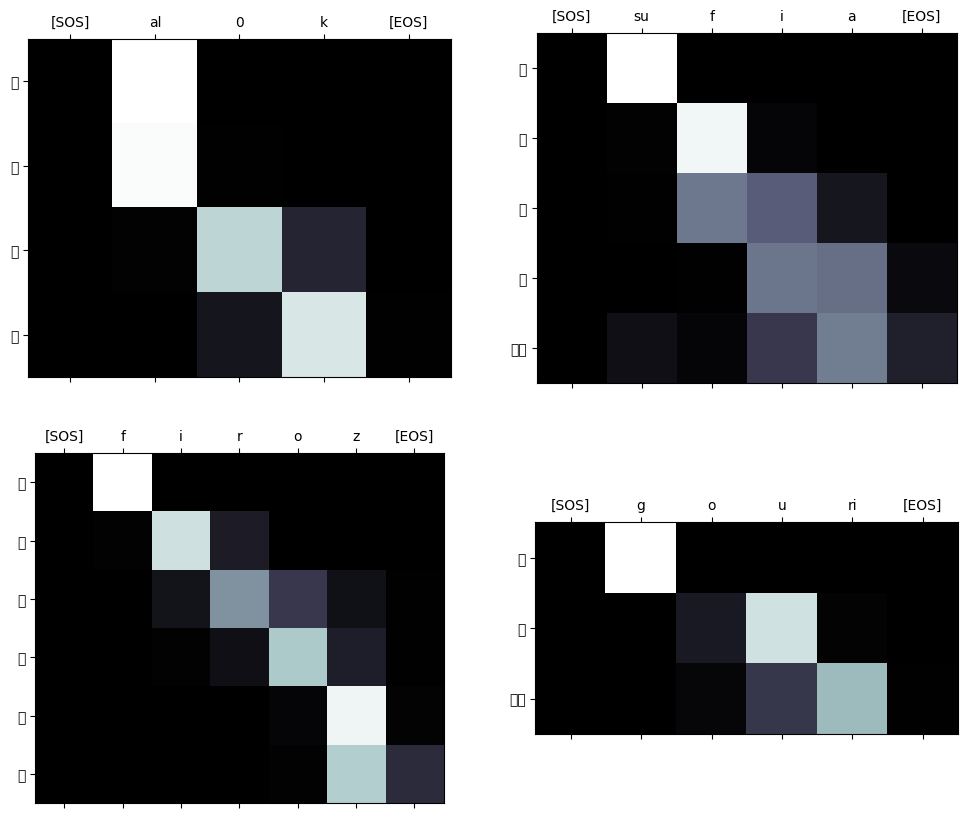

In [41]:
# Please do not change anything in the following cell.

pyplot.figure(figsize=(12, 10))

src_id_to_token = inverse_vocabulary(src_tokenizer)
tgt_id_to_token = inverse_vocabulary(tgt_tokenizer)

with torch.no_grad():
    for i, row in train_data.sample(n=4, random_state=42, ignore_index=True).iterrows():
        src_tokens = torch.tensor(src_tokenizer.encode(row['Name']))
        attentions, tgt_tokens = model.attentions(src_tokens, tgt_tokenizer.get_special_tokens()['[EOS]'], max_length=50)
        src_glyphs = apply_inverse_vocab(src_tokens.tolist(), src_id_to_token)
        tgt_glyphs = apply_inverse_vocab(tgt_tokens.tolist(), tgt_id_to_token)
        axes = pyplot.subplot(2, 2, i+1)
        visualize_attention(src_glyphs, tgt_glyphs, attentions, axes)

In [42]:
# Please do not change anything in the following cell.

output_data = []
for _, row in validation_data.iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )
    output_data.append({ 'Name': row['Name'], 'Translation': y_pred })

pd.DataFrame.from_records(output_data).to_csv(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn", "outputs.csv"), index=False
)

In [43]:
# Please do not change anything in the following cell.

# Release resources
if 'trainer' in globals():
    del trainer

if 'model' in globals():
    del model

sync_vram()

## Evaluation

In the last few modules, you have implemented different approaches towards transliteration of Indian names to Hindi. To assess how well different systems perform, it is useful to compute different metrics, which assess different properties:

- **Accuracy**: From a parallel corpus, number of translations the model got exactly right. Higher the better. Note that this makes sense only for this task. and lacks granularity.
- **Edit Distance**: Number of edits at the character level (insertions, deletions, substitutions) required to transform your model's outputs to a reference translation. Lower the better.
- **Character Error Rate (CER)**: The rate at which your system/model makes mistakes at the character level. Lower the better.
- **Token Error Rate (TER)**: The rate at which your system/model makes mistakes at the token level. Lower the better. Depending on your tokenizer implementation, could be the same as CER.
- **BiLingual Evaluation Understudy (BLEU)**: Proposed by [Papineni et al., 2002](https://aclanthology.org/P02-1040/), BLEU is a metric that assess the quality of a translation against reference translations through assessing n-gram overlap. Higher the better.

Since accents and half-letters exist as separate characters in the Unicode specification, and can change the interpretation of the output, metrics that operate at the character level will treat these separately.

In [44]:
# Please do not change anything in the following cell.

class Evaluator:
    """ Class to handle all the logic concerning the evaluation of trained models.  """

    def __init__(self, src_tokenizer, tgt_tokenizer) -> None:
        """ Initializes the evaluator.

        Args:
            src_tokenizer (Tokenizer): Tokenizer for input strings in the source language.
            tgt_tokenizer (Tokenizer): Tokenizer for output strings in the target language.
        """

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.decoding_method = None

    def set_decoding_method(self, decoding_method):
        """ Sets the decoding method to use with models.
                The evaluation function will use the set decoding method to generate outputs from the model.

        Args:
            decoding_method (function): Decoding method.
                Must accept the model instance, the input string, and tokenizers as arguments.
                Can accept additional arguments if required.
        """

        self.decoding_method = decoding_method

    @staticmethod
    def decompose(string):
        """ Decomposes a string into a set of tokens.

        Args:
            string (str): String to decompose.

        Returns:
            list[str]: List of characters from the string.
        """
        return unicodedata.normalize('NFKD', string).encode('utf-8')

    @staticmethod
    def levenshtein_distance(string1, string2):
        """ Computes the levensthein distance between two strings.

        Args:
            string1 (list[any]): Sequence A.
            string2 (list[any]): Sequence B.

        Returns:
            tuple[int, int, int]: Number of insertions + deletions, substitutions and no-ops.
        """

        costs = [
            [ 0 for j in range(len(string2)+1) ]
            for i in range(len(string1)+1)
        ]

        # Prepare matrix of costs.
        for i in range(len(string1)+1): costs[i][0] = i
        for j in range(len(string2)+1): costs[0][j] = j
        for i in range(1, len(string1)+1):
            for j in range(1, len(string2)+1):
                costs[i][j] = min(
                    costs[i][j-1] + 1,
                    costs[i-1][j] + 1,
                    costs[i-1][j-1] + (0 if string1[i-1] == string2[j-1] else 1)
                )

        # Decode matrix in backward manner for actual operation counts.
        c_ins_del, c_sub, c_noop = 0, 0, 0

        i, j = len(string1), len(string2)
        while i > 0 or j > 0:
            if i > 0 and costs[i][j] == costs[i-1][j] + 1:
                c_ins_del += 1
                i -= 1
            elif j > 0 and costs[i][j] == costs[i][j-1] + 1:
                c_ins_del += 1
                j -= 1
            elif i > 0 and j > 0:
                if string1[i-1] == string2[j-1]:
                    c_noop += 1
                else:
                    c_sub += 1
                i, j = i-1, j-1
            else:
                break

        return c_ins_del, c_sub, c_noop

    @staticmethod
    def accuracy(y_true, y_pred):
        """ Computes the accuracy of the predictions, against a reference set of predictions.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: Accuracy score, between 0 and 1.
        """
        return sum(yi_true == yi_pred for yi_true, yi_pred in zip(y_true, y_pred)) / len(y_pred)

    @classmethod
    def char_error_rate(cls, y_true, y_pred):
        """ Computes the character level error rate (CER) of the set of
            predictions against the reference translations.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: CER score, between 0 and 1. Lower the better.
        """

        cer_score = 0

        for yi_true, yi_pred in zip(y_true, y_pred):
            yi_true, yi_pred = cls.decompose(yi_true), cls.decompose(yi_pred)
            c_ins_del, c_sub, c_noop = cls.levenshtein_distance(yi_true, yi_pred)
            cer_score += (c_ins_del + c_sub) / (c_ins_del + c_sub + c_noop)

        return cer_score / len(y_true)

    def token_error_rate(self, y_true, y_pred):
        """ Computes the token level error rate (TER) of the set of
            predictions against the reference translations.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: TER score, between 0 and 1. Lower the better.
        """

        ter_score = 0

        for yi_true, yi_pred in zip(y_true, y_pred):
            yi_true = self.tgt_tokenizer.encode(yi_true, add_start=False, add_end=False)
            yi_pred = self.tgt_tokenizer.encode(yi_pred, add_start=False, add_end=False)
            t_ins_del, t_sub, t_noop = self.levenshtein_distance(yi_true, yi_pred)
            ter_score += (t_ins_del + t_sub) / (t_ins_del + t_sub + t_noop)

        return ter_score / len(y_true)

    @classmethod
    def bleu_score(cls, y_true, y_pred):
        """ Computes the average BLEU score of the set of predictions against the reference translations.

            Uses default parameters and equal weights for all n-grams, with max N = 4. (Thus computes BLEU-4).
            Uses a smoothing method for the case of missing n-grams.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: BLEU-4 score, the higher the better.
        """

        y_true = [ [ cls.decompose(yi) ] for yi in y_true ]
        y_pred = [ cls.decompose(yi) for yi in y_pred ]

        smoothing = bleu_score.SmoothingFunction()

        return bleu_score.corpus_bleu(
            y_true, y_pred,
            smoothing_function=smoothing.method1
        )

    def evaluate(self, model_path, data, reference_outputs, **decoding_kwargs):
        """ Performs the evaluation of a specified model over given data.

        Args:
            model_path (str): Path to load the model from. Must have a model.pt file.
            data (list[str]): List of input strings to translate.
            reference_outputs (list[str]): List of output strings to use as reference.
            decoding_kwargs (dict[str, any]): Additional arguments to forward to the decoding method.
                This could be for instance, max_length for a greedy decoding method.

        Raises:
            ValueError: If the decoding method is not set apriori.
        """

        if self.decoding_method is None:
            raise ValueError(f"{self.evaluate.__name__}: no decoding method is set, assign before use.")

        # Load the model to the active device.
        model = torch.load(os.path.join(model_path, 'model.pt'), map_location=self.device)

        # Set model use parameters.
        model.to(self.device)
        model.eval()

        # Generate outputs.
        generated_outputs = []
        with torch.no_grad():
            for seq_x in data:
                generated_outputs.append(self.decoding_method(
                    model, seq_x, self.src_tokenizer,
                    self.tgt_tokenizer, **decoding_kwargs
                ))

        accuracy_score = self.accuracy(reference_outputs, generated_outputs)
        cer_score      = self.char_error_rate(reference_outputs, generated_outputs)
        ter_score      = self.token_error_rate(reference_outputs, generated_outputs)
        blue_score     = self.bleu_score(reference_outputs, generated_outputs)

        print("EVALUATION:", ">", "accuracy:", f"{accuracy_score:.2%}")
        print("EVALUATION:", ">", "CER     :", f"{cer_score:.2%}")
        print("EVALUATION:", ">", "TER     :", f"{ter_score:.2%}")
        print("EVALUATION:", ">", "BLEU    :", f"{blue_score:.4f}")
        print()

        # Free resources once evaluation is complete.
        del model
        sync_vram()

In [45]:
# Please do not change anything in the following cell.

evaluator = Evaluator(src_tokenizer, tgt_tokenizer)

# Use greedy decoding for producing outputs.
evaluator.set_decoding_method(rnn_greedy_generate)

# Evaluate enc-dec-rnn
print("EVALUATION:", "enc-dec-rnn")
evaluator.evaluate(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec"),
    validation_data['Name'], validation_data['Translation'],
    max_length = rnn_enc_dec_data_params['tgt_padding']
)

# Evaluate enc-dec-rnn-attn
print("EVALUATION:", "enc-dec-rnn-attn")
evaluator.evaluate(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn"),
    validation_data['Name'], validation_data['Translation'],
    max_length = rnn_enc_dec_attn_data_params['tgt_padding']
)

EVALUATION: enc-dec-rnn
EVALUATION: > accuracy: 32.00%
EVALUATION: > CER     : 18.26%
EVALUATION: > TER     : 28.20%
EVALUATION: > BLEU    : 0.7782

EVALUATION: enc-dec-rnn-attn
EVALUATION: > accuracy: 46.25%
EVALUATION: > CER     : 11.42%
EVALUATION: > TER     : 19.53%
EVALUATION: > BLEU    : 0.8674



## (**Bonus**) Decoding Strategies

A conditional language model aims to learn $P_\theta(y | x)$, that is, the probability of the target sequence being $y$ when the input sequence is $x$. This is modeled as $P_{\theta}(y | x) = \prod_{i=1}^{|y|} {P_\theta(y_i | x, y_{1:i-1})}$.

For translation, our goal is to find the sequence that maximizes this conditional probability, i.e. $y^* = \arg \max_{y} P_\theta(y | x)$. $y^*$ is then the 'best' translation for the input sequence $x$. However, computing probabilities for all possible $y$ to find the maximizer is intractable. As a result, decoding strategies are employed to produce reasonable approximations of $y^*$.

In the last module, you evaluated your models through different metrics, but the approach for generating outputs from the model was fixed to greedy decoding, where at each time step, the token to be produced is determined by $y_{i,greedy} := \arg \max_{y_i} P(y_i| x, y_{1:i-1})$. While this approach is fast, $P(y_{greedy}|x)$ may be much less than $P(y^*|x)$. Fortunately, better decoding strategies exist to produce better approximations, however at the cost of higher time complexity. Some of these are:

- **Beam-Search Decoding**: At every time step, retains $k$ candidate token generations, which are decoded individually (each path is referred as a beam) to obtain $k$ successors per beam. For the next time step, the best $k$ candidates are retained such that conditional probability of the sequence generated so far is maximized. Has a complexity of $O(kV|y|)$, where $V$ is the size of the target vocabulary, and $|y|$ is the target sequence length. Using $k=1$ makes it equivalent to greedy decoding. Implementations also employ length penalties to not be biased towards larger target sequences.

- **Viterbi Decoding**: A decoding technique based on the Viterbi algorithm, which is a dynamic programming algorithm that provides an efficient way of finding the "most likely state sequence in the maximum a posteriori probability sense of a process assumed to be a finite-state discrete-time Markov process". Works well under assumptions of a small target vocabulary size and conditional independence of feature vectors. The decoded sequence has the minimum error probability possible when compared to $y^*$, i.e., $P(y_{viterbi}|x) \sim P(y^* | x)$. Has a time complexity of $O(V^2|y|)$.

In the next cell, you will implement any preferred decoding strategy of your choice, and compare performances of different decoding strategies.

**Note**: This module is optional, and can be attempted for a bonus score. If you choose to attempt this module, please set the variable `ATTEMPTED_BONUS` (declared below) to `True`, as this will impact the evaluation of the bonus part.

In [46]:
## ==== BEGIN EVALUATION PORTION

# ADD YOUR CODE HERE
# Set this variable to True if you choose to implement the function `rnn_better_generate` for the bonus module.
# Regardless of your choice, please run this cell.
ATTEMPTED_BONUS = False

## ==== END EVALUATION PORTION

print("EVALUATION:", "Attempted Bonus Module?", ATTEMPTED_BONUS)

EVALUATION: Attempted Bonus Module? False


In [47]:
## ==== BEGIN EVALUATION PORTION

# Feel free to add additional parameters to rnn_better_generate, such as k for Beam Search Decoding.
def rnn_better_generate(model, seq_x, src_tokenizer, tgt_tokenizer, max_length, k=5, length_penalty_alpha=0.6):
    """ Given a source string, translate it to the target language using the trained model.
        This function should use a better decoding strategy than greedy decoding (see above) to generate the results.

    Args:
        model (nn.Module): RNN Type Encoder-Decoder Model
        seq_x (str): Input string to translate.
        src_tokenizer (Tokenizer): Source language tokenizer.
        tgt_tokenizer (Tokenizer): Target language tokenizer.
        max_length (int): Maximum length of the target sequence to decode.

    Returns:
        str: Generated string for the given input in the target language.
    """

    # BEGIN CODE : enc-dec-rnn.better_generate

    # ADD YOUR CODE HERE
    model.eval()
    with torch.no_grad():
        print(seq_x)
        seq_x = src_tokenizer.encode(seq_x, add_start=True, add_end=True)
        seq_x = torch.tensor([seq_x]).to(model.device)
        beam = []
        decoder_input = torch.tensor([[tgt_tokenizer.vocab[tgt_tokenizer.START_TOKEN]]]).to(model.device)
        output, hidden_state = model(seq_x, decoder_input, None)
        output = torch.topk(output, k, dim=2)
        for i in range(k):
            beam.append({
                'tokens': [output.indices[0, 0, i]], 
                'hidden_states': hidden_state, 
                'score': model.log_probability(seq_x, torch.tensor([output.indices[0, 0, i]]).to(model.device))
            })
        for t in range(1, max_length):
            new_beam = []
            for i in range(k):
                token = beam[i]['tokens'][-1]
                output, hidden_state = model(seq_x, torch.tensor([[token]]).to(model.device), beam[i]['hidden_states'])
                output = torch.topk(output, k, dim=2)
                for j in range(k):
                    a = torch.tensor(tgt_tokenizer.vocab[tgt_tokenizer.START_TOKEN]).to(model.device)
                    b = beam[i]['tokens'] 
                    c = output.indices[0, 0, j]
                    d = torch.tensor(tgt_tokenizer.vocab[tgt_tokenizer.END_TOKEN]).to(model.device)
                    add = torch.cat((a, torch.tensor(b), c, d))
                    new_beam.append({
                        'tokens': beam[i]['tokens'] + [output.indices[0, 0, j]],
                        'hidden_states': hidden_state,
                        'score': model.log_probability(seq_x, add)
                    })
            new_beam = sorted(new_beam, key=lambda x: x['score'], reverse=True)
            beam = new_beam[:k]
        print(tgt_tokenizer.decode(tgt_tokenizer.unpad(beam[0]['tokens'])))
        return tgt_tokenizer.decode(tgt_tokenizer.unpad(beam[0]['tokens']))
    # END CODE

## ==== END EVALUATION PORTION

In [48]:
## ==== BEGIN EVALUATION PORTION

# BEGIN CODE : decoding.init

# Add parameter values for your decoding strategy here. Leave empty if unused.

decoding_params = dict(
    # ADD YOUR CODE HERE
    k = 10, 
    length_penalty_alpha = 0.6
)

## ==== END EVALUATION PORTION

In [49]:
# Please do not change anything in the following cell.

evaluator = Evaluator(src_tokenizer, tgt_tokenizer)

# Use a different decoding for producing outputs.
if ATTEMPTED_BONUS:
    evaluator.set_decoding_method(rnn_better_generate)
else:
    evaluator.set_decoding_method(rnn_greedy_generate)

# # Evaluate enc-dec-rnn
# print("EVALUATION:", "enc-dec-rnn")
# evaluator.evaluate(
#     os.path.join(DIRECTORY_NAME, "rnn.enc-dec"),
#     validation_data['Name'], validation_data['Translation'],
#     max_length = rnn_enc_dec_data_params['tgt_padding'],
#     **decoding_params
# )

# Evaluate enc-dec-rnn-attn
print("EVALUATION:", "enc-dec-rnn-attn")
evaluator.evaluate(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn"),
    validation_data['Name'], validation_data['Translation'],
    max_length = rnn_enc_dec_attn_data_params['tgt_padding'],
    **decoding_params
)

EVALUATION: enc-dec-rnn-attn


TypeError: rnn_greedy_generate() got an unexpected keyword argument 'k'

## Congratulations!

You have reached the end of the last assignment! Hope this was a fun exercise!

Once you've run the cells above, you should be ready to submit the assignment.